## Customer Support Long & Short Term Memory

In [1]:
import os
import uuid
from pprint import pprint
from dotenv import load_dotenv

from langgraph.store.memory import InMemoryStore
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage

load_dotenv()

True

In [2]:
os.environ["LANGCHAIN_PROJECT"] = "langchain_customer_support_agent"
os.environ["LANGCHAIN_TRACING_V2"] = "true"

In [3]:
in_memory_store = InMemoryStore()

### Store Information in Long Term Memory

In [4]:
# Namespace for the memory to save
customer_id = "1"
namespace_for_memory = (customer_id, "customer_interactions")

# Save memory to namespace as key-value pairs
key = str(uuid.uuid4())

values = {"name": "John Doe", "email": "johndoe@example.com"}

# Save the memory to disk
in_memory_store.put(namespace=namespace_for_memory, key=key, value=values)

### Search Memory

In [5]:
memories = in_memory_store.search(namespace_for_memory)
type(memories)

list

In [6]:
memory = in_memory_store.get(namespace=namespace_for_memory, key=key)

if memory:
    print(memories[0].dict())

{'namespace': ['1', 'customer_interactions'], 'key': 'c1521901-9d8c-44ab-8b1b-5722aac8d4d7', 'value': {'name': 'John Doe', 'email': 'johndoe@example.com'}, 'created_at': '2025-02-16T21:27:44.037840+00:00', 'updated_at': '2025-02-16T21:27:44.037840+00:00', 'score': None}


##### Getting Memory Using Key and Namespace

In [7]:
memory = in_memory_store.get(namespace=namespace_for_memory, key=key)

if memory:
    print(memory.dict())

{'namespace': ['1', 'customer_interactions'], 'key': 'c1521901-9d8c-44ab-8b1b-5722aac8d4d7', 'value': {'name': 'John Doe', 'email': 'johndoe@example.com'}, 'created_at': '2025-02-16T21:27:44.037840+00:00', 'updated_at': '2025-02-16T21:27:44.037840+00:00'}


##### Delete Memory

In [8]:
in_memory_store.delete(namespace=namespace_for_memory, key=key)

In [9]:
memory = in_memory_store.get(namespace=namespace_for_memory, key=key)

if memory:
    print(memory.dict())
else:
    print("Memory not found")

Memory not found


### Creating Customer Support Agent With Long & Short Term Memory

In [10]:
openai_api_key = os.getenv("OPENAI_API_KEY")

model = ChatOpenAI(model_name="gpt-4o", openai_api_key = openai_api_key)

In [11]:
COMPANY_NAME = "ST Penda Inc."  

MODEL_SYSTEM_MESSAGE = """You are a customer support assistant for {company_name}.
        You are here to help customers with their issues and provide them with the best possible solution.
        You are to use the customer's history to provide relevant and personalized support.
        You are here to make sure that the customers are satisfied with the services provided by {company_name}.
        Cutomer profile: {history}"""

CREATE_HISTORY_INSTRUCTION = """Update the customer profile with new support interaction details.
        
        CURRENT PROFILE: {history}
        
        ANALYZE FOR:
        1. Contact history
        2. Product usage/purchases
        3. Previous issues/resolutions
        4. Preferences (communicaion, products, etc.)
        5. Special Circumstances (e.g. returning customer, VIP, etc.)
        
        Focus on verified support interactions only. Summarize key details clearly.
        
        Update profile based on this conversation."""

### Nodes

In [12]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.store.base import BaseStore

from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_core.runnables.config import RunnableConfig

In [13]:
def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """
    Generate AI responce using customer context and history.
    
    Args:
        state: Current conversation messages
        config: Runtime configuration with customer_id
        store: Persistent storage for customer profile
        
    Returns:
        dict: Generated response messages
        
    Flow:
        1. Get customer profile from store using ID
        2. Format system prompt with customer context
        3. Generate personalized response

    """
    # Get customer ID and profile from store
    customer_id = config["configurable"]["customer_id"]
    namespace = ("customer_interactions", customer_id)
    key = "customer_data_memory"
    memory = store.get(namespace=namespace, key=key)

    # Extract interaction history or set default for new customers
    history = memory.value.get("customer_data_memory") if memory else "No existing memory found"

    # Generate response with customer context
    system_message = MODEL_SYSTEM_MESSAGE.format(history=history, company_name=COMPANY_NAME)
    response = model.invoke([SystemMessage(content=system_message)] + state["messages"])

    return {"messages": response}

In [14]:
def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """
    Updates customer interaction history in persistent storage.
    
    Args:
        state: Current conversation messages
        config: Runtime configuration with customer_id
        store: Persistent storage for customer profile
        
    Flow:
        1. Retrieves existing customer history
        2. Analyzes conversation for key details
        3. Updates stored history with new data
    
    """

    # Get customer history
    user_id = config["configurable"]["customer_id"]
    namespace = ("customer_interactions", user_id)
    key = "customer_data_memory"
    memory = store.get(namespace=namespace, key=key)

    # Extract existing history or set default for new customers
    history = memory.value.get("key") if memory else "No existing history found"

    # Generate and store updated history
    system_msg = CREATE_HISTORY_INSTRUCTION.format(history=history)
    new_details = model.invoke([SystemMessage(content=system_msg)] + state["messages"])
    store.put(namespace=namespace, key=key, value={"customer_data_memory": new_details.content})

In [15]:
# Build conversational AI system with memory persistence
builder = StateGraph(MessagesState)

# Add core processing nodes
builder.add_node("call_model", call_model)          # AI response generator
builder.add_node("write_memory", write_memory)      # Memory persistence node

# Configure processin flow
builder.add_edge(START, "call_model")               # Initial: Generate response
builder.add_edge("call_model", "write_memory")      # Next: Save conversation context
builder.add_edge("write_memory", END)               # Finally: Complete interaction cycle

# Initialize memory stores
across_thread_memory = InMemoryStore()              # Long-term customer history storage
within_thread_memory = MemorySaver()                # Current conversation buffer

# Compile graph with memory configuration
graph = builder.compile(
    checkpointer=within_thread_memory,              # Track conversation state
    store=across_thread_memory,                     # Persist customer interactions
)


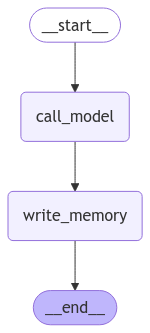

In [16]:
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [17]:
# Initialize conversation configuration
config = {
    "configurable": {
        "thread_id": "1",       # Current conversation ID
        "customer_id": "1"      # Customer profile ID
    }
}

In [ ]:
# Set initial conversation message
input_msg = [HumanMessage(content="Hello, My name is Samuel Terhemen and i would like to know about your car maintenance services")]

# Process conversations with streaming response
for chunk in graph.stream({"messages": input_msg}, config, stream_mode="values"):   # Message content, Config parameters, Stream format
    chunk["messages"][-1].pretty_print()  # Print last message in the chunk

c:\Users\penda\Desktop\Workspace\My_Projects\Agentic_AI\Agentic_AI_Langgraph\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


================================ Human Message =================================

Hello, My name is Samuel Terhemen and i would like to know about your car maintenance services


Failed to multipart ingest runs: langsmith.utils.LangSmithAuthError: Authentication failed for https://api.smith.langchain.com/runs/multipart. HTTPError('401 Client Error: Unauthorized for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Unauthorized"}\n')trace=136ca1ed-30c1-470d-885f-28859b94a416,id=136ca1ed-30c1-470d-885f-28859b94a416; trace=136ca1ed-30c1-470d-885f-28859b94a416,id=a9bb17b7-ea4c-4a0e-80fc-aa4e6cd27bd8; trace=136ca1ed-30c1-470d-885f-28859b94a416,id=fbaa81b3-5490-462d-bf30-24d6a6e8e9be; trace=136ca1ed-30c1-470d-885f-28859b94a416,id=5c09914c-a4b8-459a-adb4-844d2eb72cc8; trace=136ca1ed-30c1-470d-885f-28859b94a416,id=4efa4d54-5466-4fa7-92ff-efbb25a60343; trace=136ca1ed-30c1-470d-885f-28859b94a416,id=881024e3-5ecd-4141-8651-08c3a1c86e2e


================================== Ai Message ==================================

Hello Samuel! Thank you for reaching out to us. At ST Penda Inc., we offer a range of car maintenance services to keep your vehicle in top condition. Our services include:

1. **Oil and Filter Change**: Regular oil changes to keep your engine running smoothly.
2. **Brake Inspection and Repair**: Ensuring your brakes are functioning correctly for safe driving.
3. **Tire Services**: Including tire rotation, balancing, and replacement.
4. **Battery Check and Replacement**: Making sure your battery is in good health or replacing it if needed.
5. **Fluid Checks and Top-Ups**: Checking and topping up all essential fluids like coolant, brake fluid, transmission fluid, etc.
6. **Engine Diagnostics**: Using the latest technology to diagnose and fix engine issues.
7. **Regular Maintenance Packages**: Tailored to your vehicle's specific needs.

If you have any specific questions or need advice on any issue you're ex

Failed to send compressed multipart ingest: langsmith.utils.LangSmithAuthError: Authentication failed for https://api.smith.langchain.com/runs/multipart. HTTPError('401 Client Error: Unauthorized for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Unauthorized"}\n')


In [19]:
# Set initial conversation message
input_msgs = [HumanMessage(content="Last time i visited your shop, i was told i can enroll for a monthly maintenance plan. What are the available plans and cost?")]

# Process conversations with streaming response
for chunk in graph.stream({"messages": input_msgs}, config, stream_mode="values"):  
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Last time i visited your shop, i was told i can enroll for a monthly maintenance plan. What are the available plans and cost?
================================== Ai Message ==================================

At ST Penda Inc., we offer several monthly maintenance plans designed to meet different needs and budgets. Here’s a brief overview of our available plans:

1. **Basic Maintenance Plan**:
   - **Includes**: Oil change, tire rotation, and basic vehicle inspection.
   - **Cost**: $29.99 per month.

2. **Standard Maintenance Plan**:
   - **Includes**: Oil change, tire rotation, brake inspection, fluid top-ups, and full vehicle inspection.
   - **Cost**: $49.99 per month.

3. **Premium Maintenance Plan**:
   - **Includes**: All services from the Standard Plan plus battery check, engine diagnostics, and priority customer service.
   - **Cost**: $79.99 per month.

Each plan is designed to ensure your vehicle

Failed to send compressed multipart ingest: langsmith.utils.LangSmithAuthError: Authentication failed for https://api.smith.langchain.com/runs/multipart. HTTPError('401 Client Error: Unauthorized for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Unauthorized"}\n')
Failed to send compressed multipart ingest: langsmith.utils.LangSmithAuthError: Authentication failed for https://api.smith.langchain.com/runs/multipart. HTTPError('401 Client Error: Unauthorized for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Unauthorized"}\n')
Failed to send compressed multipart ingest: langsmith.utils.LangSmithAuthError: Authentication failed for https://api.smith.langchain.com/runs/multipart. HTTPError('401 Client Error: Unauthorized for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Unauthorized"}\n')


In [20]:
customer_id = "1"
namespace = ("customer_interactions", customer_id)

existing_memory = across_thread_memory.get(namespace=namespace, key="customer_data_memory")

existing_memory.dict()

{'namespace': ['customer_interactions', '1'],
 'key': 'customer_data_memory',
 'value': {'customer_data_memory': 'To update your customer profile:\n\n1. **Contact History**: Samuel Terhemen has inquired about car maintenance services and monthly maintenance plans.\n2. **Product Usage/Purchases**: Information not provided; indicated interest in potentially enrolling for a monthly maintenance plan.\n3. **Previous Issues/Resolutions**: None mentioned.\n4. **Preferences**: Interested in detailed information about monthly maintenance plans and cost structures.\n5. **Special Circumstances**: Returning customer as he mentioned the last visit and previous suggestion about a monthly maintenance plan.\n\nSamuel could benefit from enrolling in a plan that suits his maintenance needs and budget preferences. Consider following up to assist with plan selection and enrollment logistics.'},
 'created_at': '2025-02-16T21:27:57.372258+00:00',
 'updated_at': '2025-02-16T21:27:57.372258+00:00'}

In [29]:
for key, value in existing_memory.dict().get("value").items():
    print(key, value)

customer_data_memory To update your customer profile:

1. **Contact History**: Samuel Terhemen has inquired about car maintenance services and monthly maintenance plans.
2. **Product Usage/Purchases**: Information not provided; indicated interest in potentially enrolling for a monthly maintenance plan.
3. **Previous Issues/Resolutions**: None mentioned.
4. **Preferences**: Interested in detailed information about monthly maintenance plans and cost structures.
5. **Special Circumstances**: Returning customer as he mentioned the last visit and previous suggestion about a monthly maintenance plan.

Samuel could benefit from enrolling in a plan that suits his maintenance needs and budget preferences. Consider following up to assist with plan selection and enrollment logistics.


In [30]:
thread = {"configurable": {"thread_id": "1"}}
state = graph.get_state(thread).values

for m in state["messages"]:
    m.pretty_print()

================================ Human Message =================================

Hello, My name is Samuel Terhemen and i would like to know about your car maintenance services
================================== Ai Message ==================================

Hello Samuel! Thank you for reaching out to us. At ST Penda Inc., we offer a range of car maintenance services to keep your vehicle in top condition. Our services include:

1. **Oil and Filter Change**: Regular oil changes to keep your engine running smoothly.
2. **Brake Inspection and Repair**: Ensuring your brakes are functioning correctly for safe driving.
3. **Tire Services**: Including tire rotation, balancing, and replacement.
4. **Battery Check and Replacement**: Making sure your battery is in good health or replacing it if needed.
5. **Fluid Checks and Top-Ups**: Checking and topping up all essential fluids like coolant, brake fluid, transmission fluid, etc.
6. **Engine Diagnostics**: Using the latest technology to diagnose